# Visualize grit calculated per compartment

Previously, we calculated grit using the following subsets:

* Per compartment (Cells, Cytoplasm, Nuclei)
* Per compartment feature group (Cells x AreaShape, Cells x Correlation, Nuclei x Texture, etc.)
* Per channel (DNA, RNA, AGP, ER, Mito)
    * Use all features that include any information from one of these channels
* No feature subsetting

Here, we visualize these results.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import plotnine as gg

In [2]:
output_dir = pathlib.Path("figures/compartment_drop")

cell_health_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_map.tsv")
compartment_grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_map_compartments.tsv.gz")

In [3]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

compartment_drop_theme = gg.theme(
    strip_background=gg.element_rect(color="black", fill="#fdfff4"),
    strip_text_x=gg.element_text(size=6),
    axis_text=gg.element_text(size=7),
    axis_title=gg.element_text(size=8),
    legend_title=gg.element_text(size=6),
    legend_text=gg.element_text(size=5),
    panel_grid=gg.element_line(size=0.35),
)

grit_results = (
    pd.read_csv(grit_file, sep="\t")
    .assign(compartment="all", feature_group="all", channel="all")
    .query("barcode_control == 'cutting_control'")
    # .query("grit_replicate_summary_method == 'mean'")
    # .query("cor_method == 'pearson'")
)

grit_results = grit_results.assign(num_features=grit_results.shape[0])
compartment_grit_results = pd.read_csv(compartment_grit_file, sep="\t")
compartment_grit_results

,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control,compartment,channel,feature_group,num_features,dropped_or_exclusive
0,AKT1,AKT1-1,0.243094,0.084708,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped
1,AKT1,AKT1-2,0.206240,0.101630,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped
2,ARID1B,ARID1B-1,0.122818,0.155451,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped
3,ARID1B,ARID1B-2,0.126775,0.125047,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped
4,ATF4,ATF4-1,0.334947,0.024968,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17653,TXN,TXN-2,0.178000,0.134714,11.0,203.0,ES2,cutting_control,all,ER,all,68,exclusive
17654,XBP,XBP-1,0.322996,0.081550,11.0,203.0,ES2,cutting_control,all,ER,all,68,exclusive
17655,XBP,XBP-2,0.357187,0.012599,11.0,203.0,ES2,cutting_control,all,ER,all,68,exclusive
17656,YAP1,YAP1-1,0.587410,0.006545,11.0,203.0,ES2,cutting_control,all,ER,all,68,exclusive


In [4]:
compartment_grit_results["-log10(p-value)"] = -np.log10(compartment_grit_results["p_value"])

## 1) Per compartment grit

In [5]:
per_compartment_df = (
    compartment_grit_results.query("compartment != 'all'").query("feature_group == 'all'").query("channel == 'all'")
)

print(pd.crosstab(per_compartment_df.num_features, per_compartment_df.compartment))

print(per_compartment_df.shape)
per_compartment_df.head()

compartment   Cells  Cytoplasm  Nuclei
num_features                          
100             654          0       0
142               0        654       0
153               0          0     654
(1962, 14)


,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control,compartment,channel,feature_group,num_features,dropped_or_exclusive,-log10(p-value)
0,AKT1,AKT1-1,0.243094,0.084708,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped,1.072075
1,AKT1,AKT1-2,0.206240,0.101630,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped,0.992979
2,ARID1B,ARID1B-1,0.122818,0.155451,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped,0.808406
3,ARID1B,ARID1B-2,0.126775,0.125047,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped,0.902925
4,ATF4,ATF4-1,0.334947,0.024968,11.0,203.0,HCC44,cutting_control,Cells,all,all,100,dropped,1.602625


In [6]:
per_compartment_df = per_compartment_df.pivot(
    index=["Metadata_pert_name", "Metadata_gene_name", "cell_line", "compartment"],
    values="mean_ap",
    columns="dropped_or_exclusive",
).reset_index()

per_compartment_df = (
    per_compartment_df.assign(channel_signal=per_compartment_df.exclusive - per_compartment_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_compartment_df.shape)
per_compartment_df.head(20)

(981, 7)


dropped_or_exclusive,Metadata_pert_name,Metadata_gene_name,cell_line,compartment,dropped,exclusive,channel_signal
0,EGLN1-9,EGLN1,HCC44,Cytoplasm,0.438575,0.825963,0.387388
1,EGLN1-8,EGLN1,HCC44,Cytoplasm,0.415864,0.786040,0.370176
2,CSNK1A1-1,CSNK1A1,ES2,Cytoplasm,0.263114,0.563936,0.300822
3,CDK2-1,CDK2,ES2,Nuclei,0.597300,0.845302,0.248002
4,CDK2-2,CDK2,ES2,Nuclei,0.607968,0.833766,0.225798
5,BRAF1-1,BRAF1,HCC44,Nuclei,0.076606,0.300079,0.223473
6,BRCA1-1,BRCA1,HCC44,Nuclei,0.119312,0.335453,0.216140
7,CSNK1A1-2,CSNK1A1,ES2,Cytoplasm,0.223510,0.436422,0.212912
8,BRCA1-2,BRCA1,HCC44,Nuclei,0.109804,0.308699,0.198895
9,KRAS-2A,KRAS,A549,Cytoplasm,0.352591,0.537227,0.184636


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/compartment_drop/cell_health_map_compartment_drop.png


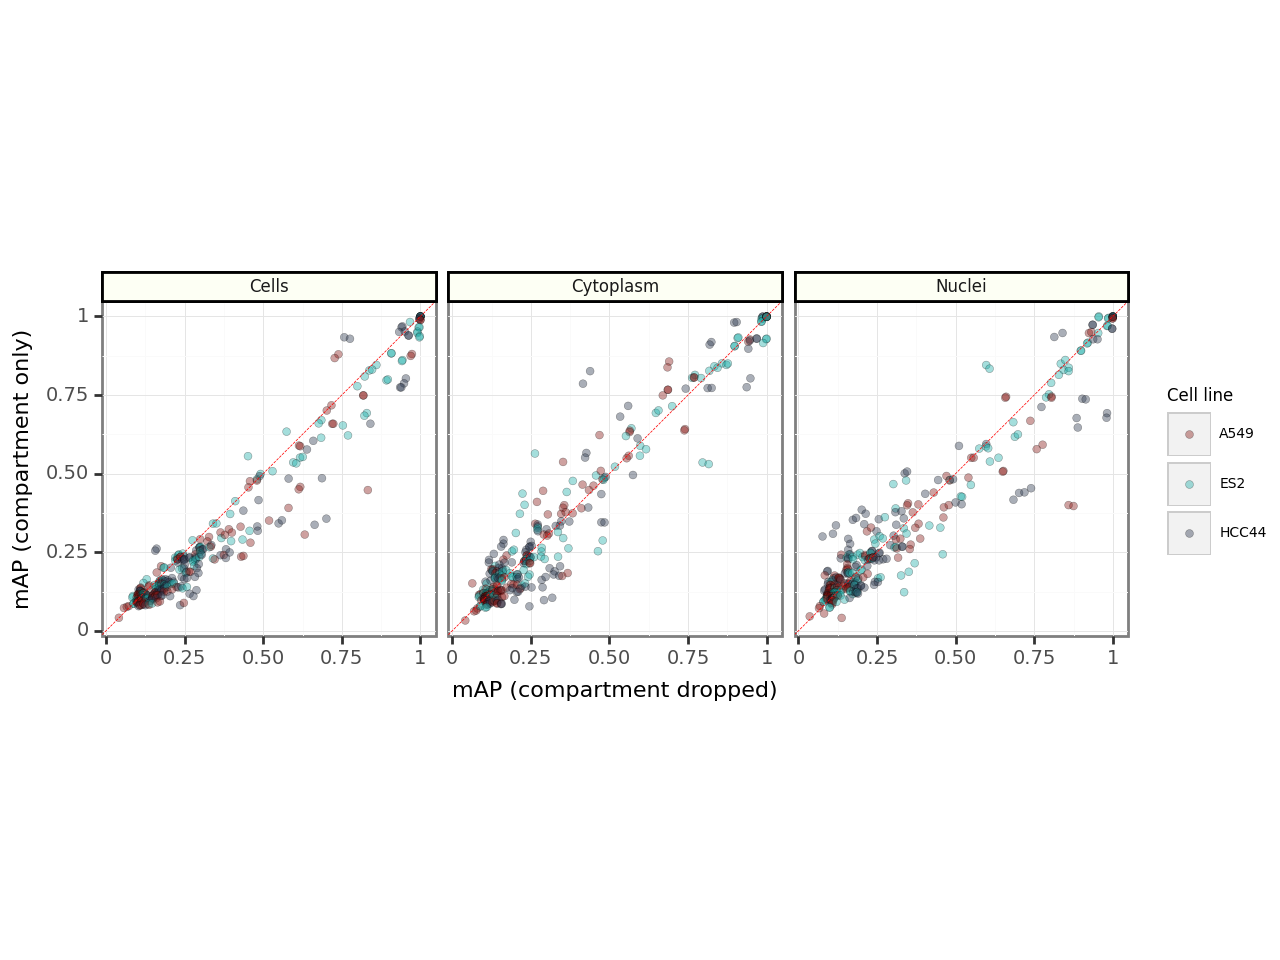

<Figure Size: (640 x 480)>

In [7]:
compartment_drop_gg = (
    gg.ggplot(per_compartment_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1.5, stroke=0.1)
    + gg.facet_grid("~compartment")
    + gg.xlab("mAP (compartment dropped)")
    + gg.ylab("mAP (compartment only)")
    + gg.coord_fixed()
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell line", values=cell_line_colors)
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_compartment_drop.png")
compartment_drop_gg.save(output_file, dpi=500, height=3, width=6)

compartment_drop_gg

In [8]:
per_compartment_df = (
    compartment_grit_results.query("compartment != 'all'").query("feature_group == 'all'").query("channel == 'all'")
)

print(pd.crosstab(per_compartment_df.num_features, per_compartment_df.compartment))

print(per_compartment_df.shape)
per_compartment_df.head()

per_compartment_df = per_compartment_df.pivot(
    index=["Metadata_pert_name", "Metadata_gene_name", "cell_line", "compartment"],
    values="-log10(p-value)",
    columns="dropped_or_exclusive",
).reset_index()

per_compartment_df = (
    per_compartment_df.assign(channel_signal=per_compartment_df.exclusive - per_compartment_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_compartment_df.shape)
per_compartment_df.head(20)

compartment   Cells  Cytoplasm  Nuclei
num_features                          
100             654          0       0
142               0        654       0
153               0          0     654
(1962, 14)
(981, 7)


dropped_or_exclusive,Metadata_pert_name,Metadata_gene_name,cell_line,compartment,dropped,exclusive,channel_signal
0,CDK2-2,CDK2,ES2,Nuclei,1.893588,4.000043,2.106455
1,BRCA1-1,BRCA1,HCC44,Nuclei,0.526250,2.533176,2.006926
2,CDK2-1,CDK2,ES2,Nuclei,2.016267,4.000043,1.983776
3,CSNK1A1-1,CSNK1A1,ES2,Cytoplasm,2.165411,4.000043,1.834633
4,PSMA1-1,PSMA1,ES2,Nuclei,1.920154,3.617478,1.697324
5,PSMA1-2,PSMA1,ES2,Nuclei,1.938481,3.628206,1.689725
6,SLC2A2-2,SLC2A2,ES2,Nuclei,1.658279,3.259681,1.601401
7,EGLN1-8,EGLN1,HCC44,Cytoplasm,2.491514,3.933097,1.441583
8,KRAS-2A,KRAS,A549,Cytoplasm,2.675761,3.958651,1.282890
9,ATP50-1,ATP50,HCC44,Nuclei,1.037153,2.189139,1.151986


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/compartment_drop/cell_health_map_pval_compartment_drop.png


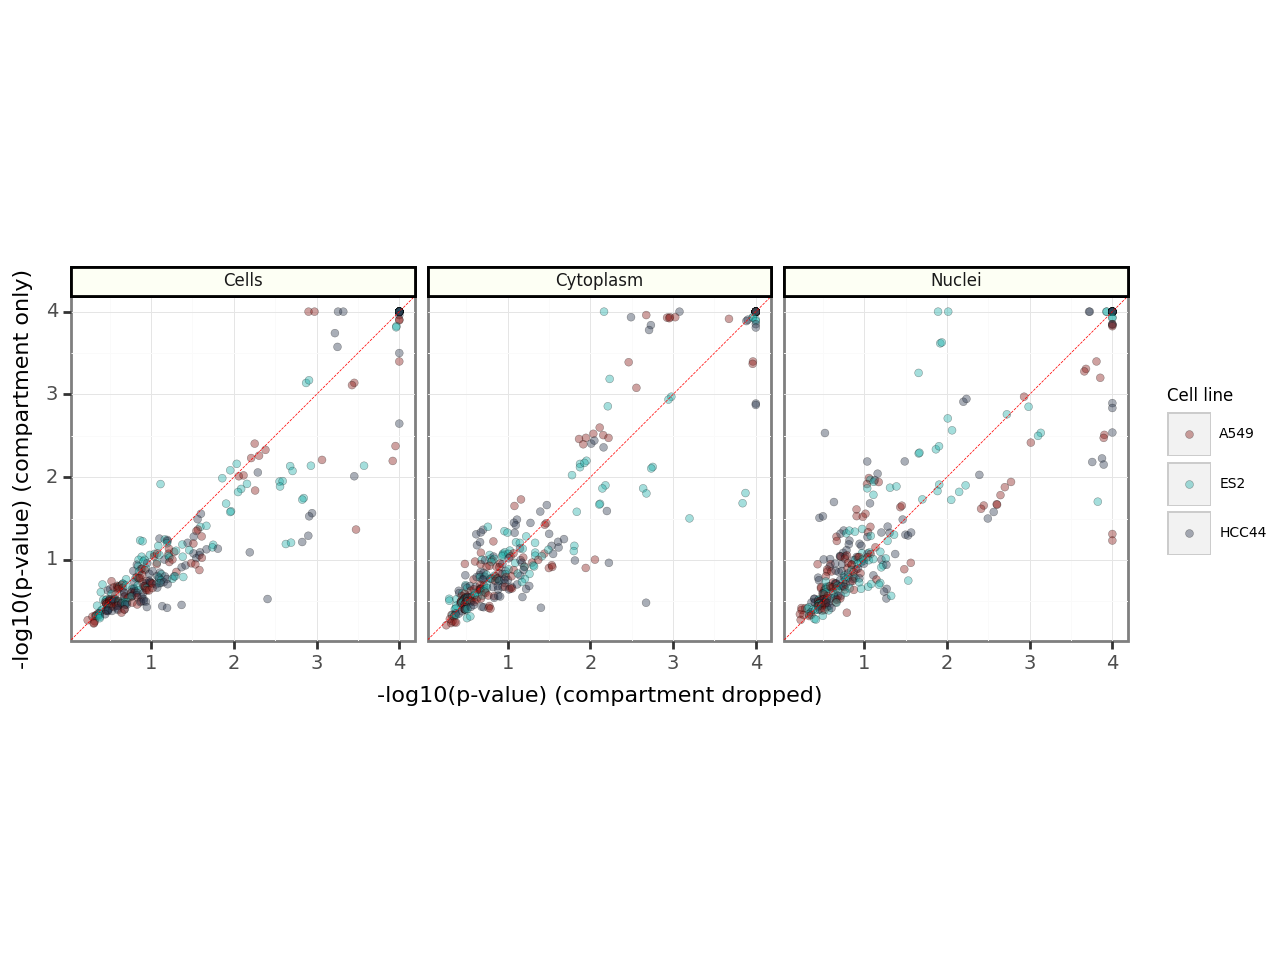

<Figure Size: (640 x 480)>

In [9]:
compartment_drop_gg = (
    gg.ggplot(per_compartment_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1.5, stroke=0.1)
    + gg.facet_grid("~compartment")
    + gg.xlab("-log10(p-value) (compartment dropped)")
    + gg.ylab("-log10(p-value) (compartment only)")
    + gg.coord_fixed()
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell line", values=cell_line_colors)
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_pval_compartment_drop.png")
compartment_drop_gg.save(output_file, dpi=500, height=3, width=6)

compartment_drop_gg

## 2) Per compartment feature group

In [10]:
per_featuregroup_df = (compartment_grit_results.query("compartment != 'all'")
    .query("feature_group != 'all'")
    .query("channel == 'all'")
    .query("feature_group != 'Location'")
).reset_index(drop=True)

per_featuregroup_df = per_featuregroup_df.pivot_table(
        index=[
            "Metadata_pert_name",
            "Metadata_gene_name",
            "cell_line",
            "channel",
            "feature_group",
            "compartment",
        ],
        values="mean_ap",
        columns="dropped_or_exclusive",
    ).reset_index()

per_featuregroup_df = (
    per_featuregroup_df.assign(channel_signal=per_featuregroup_df.exclusive - per_featuregroup_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_featuregroup_df.shape)
per_featuregroup_df.head(20)

(5886, 9)


dropped_or_exclusive,Metadata_pert_name,Metadata_gene_name,cell_line,channel,feature_group,compartment,dropped,exclusive,channel_signal
0,SLC2A1-1,SLC2A1,HCC44,all,Granularity,Cells,0.161379,0.514301,0.352922
1,BRCA1-2,BRCA1,HCC44,all,AreaShape,Nuclei,0.148298,0.444435,0.296137
2,AURKB-2,AURKB,ES2,all,Texture,Cytoplasm,0.188885,0.467421,0.278536
3,BRCA1-1,BRCA1,HCC44,all,AreaShape,Nuclei,0.162647,0.440996,0.278349
4,SLC2A1-1,SLC2A1,A549,all,Texture,Nuclei,0.111504,0.386828,0.275324
5,SLC2A1-1,SLC2A1,HCC44,all,Texture,Cytoplasm,0.148831,0.402555,0.253724
6,SLC2A2-2,SLC2A2,HCC44,all,Granularity,Cells,0.227069,0.466202,0.239133
7,CSNK1A1-1,CSNK1A1,ES2,all,RadialDistribution,Cytoplasm,0.296639,0.524587,0.227947
8,BRAF-2,BRAF,HCC44,all,Texture,Nuclei,0.110058,0.288460,0.178401
9,EZH2-2,EZH2,ES2,all,Texture,Nuclei,0.321264,0.494180,0.172916


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/compartment_drop/cell_health_map_featuregroup_drop.png


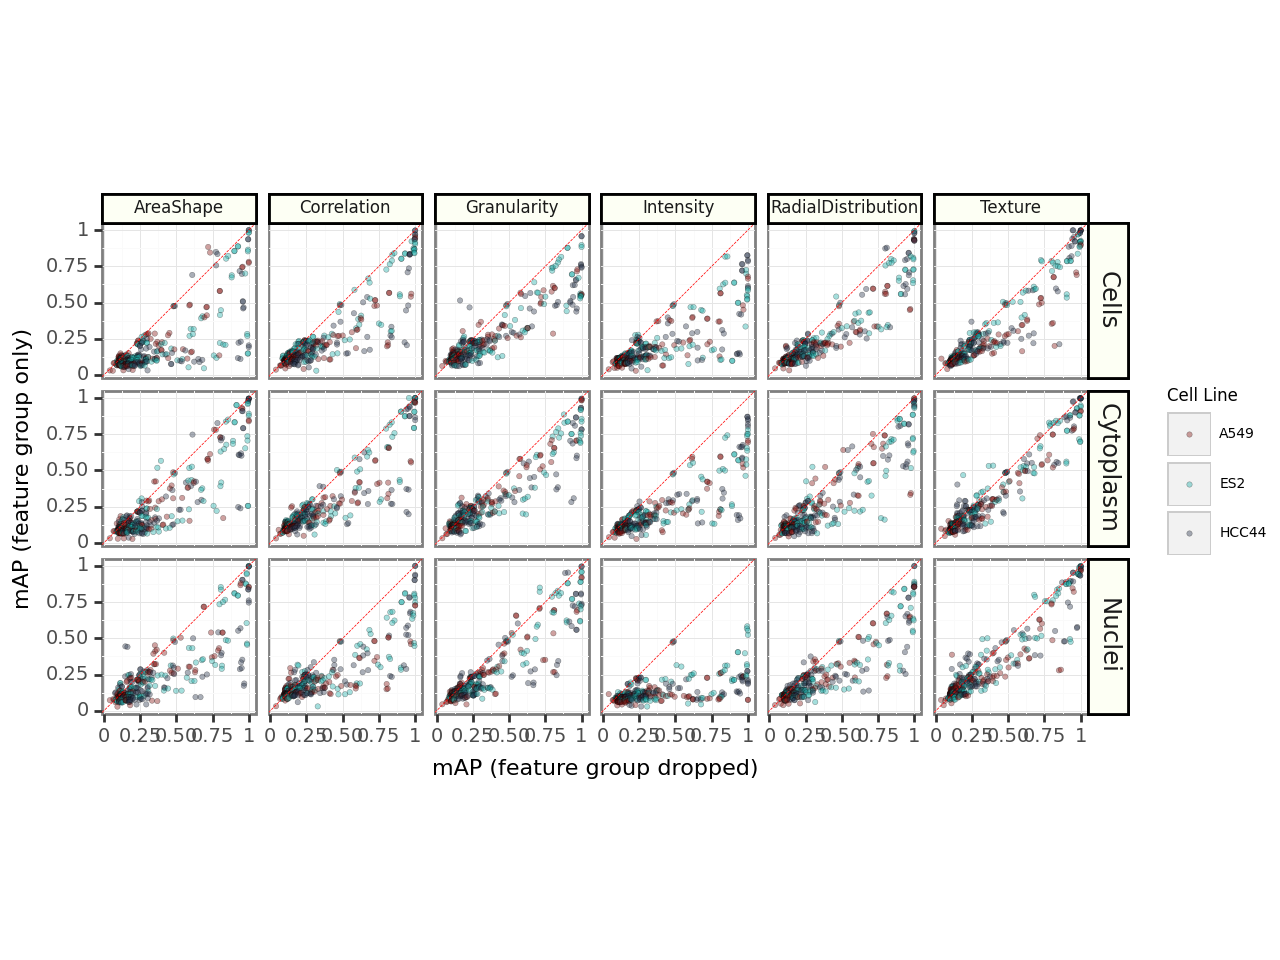

<Figure Size: (640 x 480)>

In [11]:
feature_group_drop_gg = (
    gg.ggplot(per_featuregroup_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1.0, stroke=0.1)
    + gg.facet_grid("compartment~feature_group")
    + gg.xlab("mAP (feature group dropped)")
    + gg.ylab("mAP (feature group only)")
    + gg.coord_fixed()
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_featuregroup_drop.png")
feature_group_drop_gg.save(output_file, dpi=500, height=6, width=8)

feature_group_drop_gg

In [12]:
per_featuregroup_df = (compartment_grit_results.query("compartment != 'all'")
    .query("feature_group != 'all'")
    .query("channel == 'all'")
    .query("feature_group != 'Location'")
).reset_index(drop=True)

per_featuregroup_df = per_featuregroup_df.pivot_table(
        index=[
            "Metadata_pert_name",
            "Metadata_gene_name",
            "cell_line",
            "channel",
            "feature_group",
            "compartment",
        ],
        values="-log10(p-value)",
        columns="dropped_or_exclusive",
    ).reset_index()

per_featuregroup_df = (
    per_featuregroup_df.assign(channel_signal=per_featuregroup_df.exclusive - per_featuregroup_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_featuregroup_df.shape)
per_featuregroup_df.head(20)

(5886, 9)


dropped_or_exclusive,Metadata_pert_name,Metadata_gene_name,cell_line,channel,feature_group,compartment,dropped,exclusive,channel_signal
0,GPX4-2,GPX4,ES2,all,RadialDistribution,Nuclei,1.253954,4.000043,2.746089
1,GPX4-1,GPX4,ES2,all,RadialDistribution,Nuclei,1.332980,4.000043,2.667064
2,SLC2A1-1,SLC2A1,A549,all,Texture,Nuclei,0.886825,2.933097,2.046272
3,PSMA1-1,PSMA1,A549,all,AreaShape,Nuclei,1.485582,3.526081,2.040499
4,PSMA1-2,PSMA1,A549,all,AreaShape,Nuclei,1.504008,3.538270,2.034262
5,PSMA1-1,PSMA1,ES2,all,Texture,Nuclei,1.943304,3.963831,2.020527
6,PSMA1-2,PSMA1,ES2,all,Texture,Nuclei,1.961622,3.965281,2.003659
7,PTK2-1,PTK2,ES2,all,AreaShape,Cytoplasm,1.915467,3.853915,1.938448
8,BRCA1-2,BRCA1,HCC44,all,AreaShape,Nuclei,0.783570,2.664251,1.880682
9,POLR2D-2,POLR2D,ES2,all,AreaShape,Nuclei,1.700355,3.568338,1.867982


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/compartment_drop/cell_health_map_pval_featuregroup_drop.png


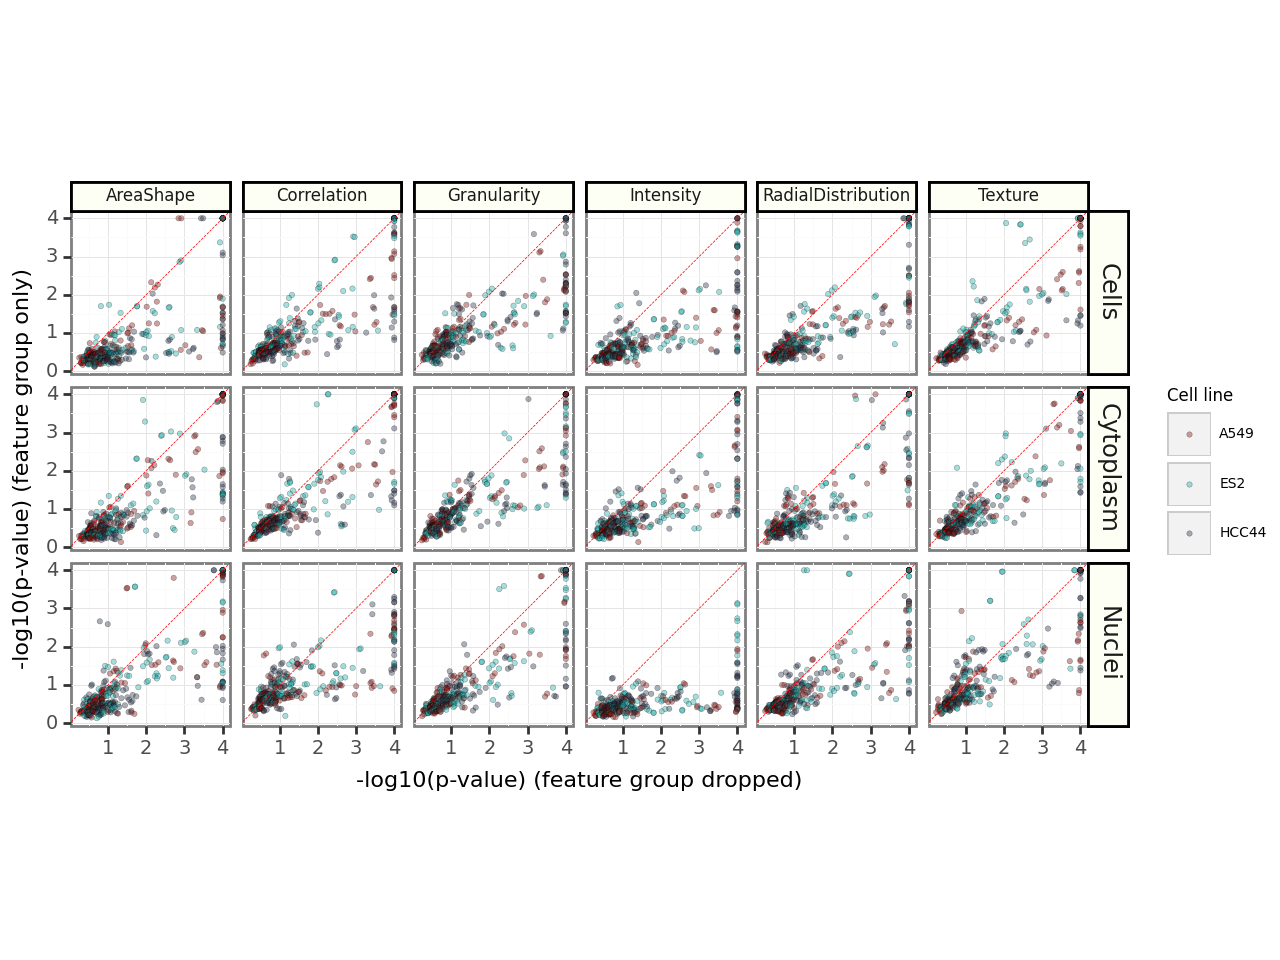

<Figure Size: (640 x 480)>

In [13]:
feature_group_drop_gg = (
    gg.ggplot(per_featuregroup_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1.0, stroke=0.1)
    + gg.facet_grid("compartment~feature_group")
    + gg.xlab("-log10(p-value) (feature group dropped)")
    + gg.ylab("-log10(p-value) (feature group only)")
    + gg.coord_fixed()
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell line", values=cell_line_colors)
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_pval_featuregroup_drop.png")
feature_group_drop_gg.save(output_file, dpi=500, height=6, width=8)

feature_group_drop_gg

## 3) Per channel grit

In [14]:
per_channel_df = (
    compartment_grit_results.query("compartment == 'all'")
    .query("feature_group == 'all'")
    .query("channel != 'all'")
).reset_index(drop=True)

per_channel_df = per_channel_df.pivot_table(
        index=["Metadata_pert_name", "Metadata_gene_name", "cell_line", "channel"],
        values="mean_ap",
        columns="dropped_or_exclusive",
).reset_index()

per_channel_df = (
    per_channel_df.assign(channel_signal=per_channel_df.exclusive - per_channel_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_channel_df.shape)
per_channel_df.head(10)

(1635, 7)


dropped_or_exclusive,Metadata_pert_name,Metadata_gene_name,cell_line,channel,dropped,exclusive,channel_signal
0,SLC2A1-1,SLC2A1,A549,Mito,0.048086,0.514056,0.465970
1,EGLN1-9,EGLN1,HCC44,Mito,0.478555,0.823121,0.344566
2,EGLN1-8,EGLN1,HCC44,Mito,0.449211,0.782298,0.333086
3,EGLN1-8,EGLN1,ES2,Mito,0.681936,0.985205,0.303269
4,EGLN1-9,EGLN1,ES2,Mito,0.697853,0.983860,0.286007
5,COX5B-1,COX5B,A549,Mito,0.102882,0.386281,0.283398
6,SLC2A1-1,SLC2A1,HCC44,Mito,0.117289,0.399398,0.282109
7,COX5B-2,COX5B,A549,Mito,0.099728,0.374793,0.275065
8,CSNK1A1-1,CSNK1A1,A549,ER,0.699874,0.917017,0.217144
9,SDHB-1,SDHB,ES2,Mito,0.221994,0.431698,0.209704


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/compartment_drop/cell_health_map_channel_drop.png


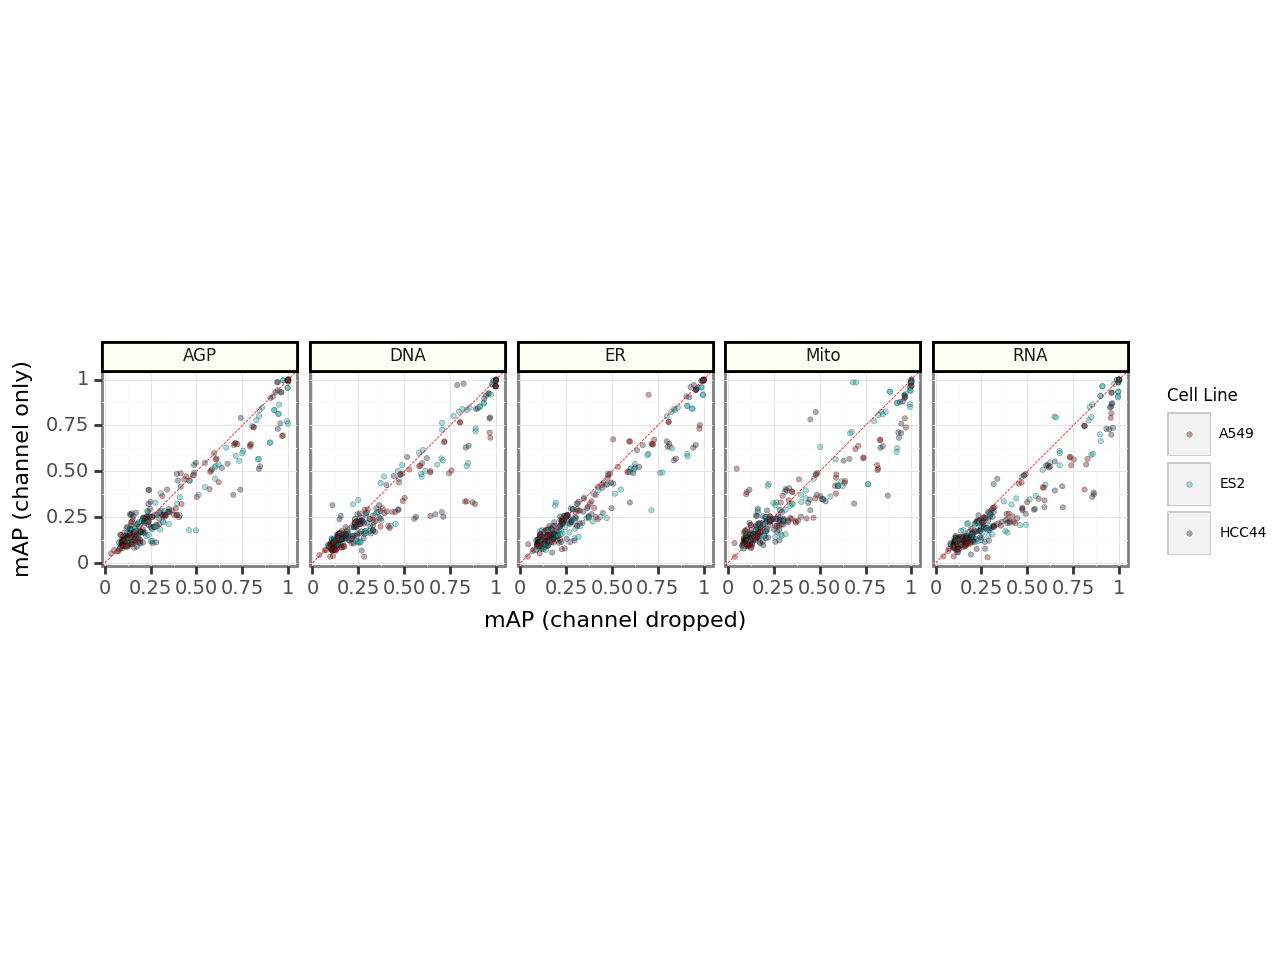

<Figure Size: (640 x 480)>

In [17]:
channel_drop_gg = (
    gg.ggplot(per_channel_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1.0, stroke=0.1)
    + gg.facet_grid("~channel")
    + gg.xlab("mAP (channel dropped)")
    + gg.ylab("mAP (channel only)")
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.coord_fixed()
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_channel_drop.png")
channel_drop_gg.save(output_file, dpi=500, height=3, width=6)

channel_drop_gg

In [18]:
per_channel_df = (
    compartment_grit_results.query("compartment == 'all'")
    .query("feature_group == 'all'")
    .query("channel != 'all'")
).reset_index(drop=True)

per_channel_df = per_channel_df.pivot_table(
        index=["Metadata_pert_name", "Metadata_gene_name", "cell_line", "channel"],
        values="-log10(p-value)",
        columns="dropped_or_exclusive",
).reset_index()

per_channel_df = (
    per_channel_df.assign(channel_signal=per_channel_df.exclusive - per_channel_df.dropped)
    .sort_values(by="channel_signal", ascending=False)
    .reset_index(drop=True)
)

print(per_channel_df.shape)
per_channel_df.head(10)

(1635, 7)


dropped_or_exclusive,Metadata_pert_name,Metadata_gene_name,cell_line,channel,dropped,exclusive,channel_signal
0,DOT1L-2,DOT1L,HCC44,RNA,1.085935,3.134742,2.048807
1,PSMA1-1,PSMA1,ES2,RNA,2.052354,4.000043,1.947689
2,PSMA1-2,PSMA1,ES2,RNA,2.070625,4.000043,1.929419
3,EGLN1-8,EGLN1,HCC44,Mito,2.111209,3.933097,1.821888
4,SLC2A1-1,SLC2A1,A549,Mito,0.447477,2.268992,1.821516
5,PSMA1-1,PSMA1,ES2,ER,2.230634,3.930407,1.699773
6,PSMA1-2,PSMA1,ES2,ER,2.248796,3.933097,1.684300
7,YAP1-1,YAP1,ES2,RNA,2.577543,4.000043,1.422500
8,YAP1-2,YAP1,ES2,RNA,2.613842,4.000043,1.386202
9,COX5B-2,COX5B,A549,Mito,0.466939,1.816062,1.349123


In [ ]:
channel_drop_gg = (
    gg.ggplot(per_channel_df, gg.aes(x="dropped", y="exclusive"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1.0, stroke=0.1)
    + gg.facet_grid("~channel")
    + gg.xlab("-log10(p-value) (channel dropped)")
    + gg.ylab("-log10(p-value) (channel only)")
    + gg.geom_abline(intercept=0, slope=1, size=0.15, color="red", linetype="dashed")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.coord_fixed()
    + gg.theme_bw()
    + compartment_drop_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_channel_drop.png")
channel_drop_gg.save(output_file, dpi=500, height=3, width=6)

channel_drop_gg